In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.4.5.post1 anndata==0.7.1 umap==0.3.9 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-13'
results_prefix=DATA+'/'+PROTEIN+'/processed_data/A549.'+PROTEIN


In [3]:
bcldirs=['180515_SL-HXR_0665_AFCHH2H3CCXY','180515_SL-HXS_0555_AFCHGYTGCCXY',
        '180515_SL-HXR_0666_BFCHGY7FCCXY','180515_SL-HXS_0556_BFCHH2FNCCXY']

for channel in range(32):
    print(channel)
    channelname=str(channel+1)
    for bcldir in bcldirs:
        gbc_cbc_file='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/data/count_barcodes/mismatches0/'+bcldir+'/A549_'+PROTEIN+'_'+channelname+'.'+bcldir+'.variantBarcodeCounts.gz.with_cellbc_and_UMI.gz'
        cur_data=pd.read_csv(gbc_cbc_file,compression='gzip',sep='\t',header=None)
        cur_data.columns=['gbc','r2','pos','strand','cbc','umi','alignments','read_name']
        cur_data['cbc']=cur_data['cbc']+'ch'+str(channel)
        if channel==0:
            gbc_data=cur_data
        else:
            gbc_data=pd.concat([gbc_data,cur_data])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [4]:
import copy
gbc_data_original=copy.deepcopy(gbc_data)
gbc_data_original=gbc_data_original.drop_duplicates()
gbc_data.shape

(873672, 8)

In [5]:
def compute_TPT(gbcs_dataset):
    
    '''
    input: pandas data frame with the columns "cbc", "umi", "gbc", "r2" where every row is a read 
    output: pandas data frame with the columns "gbc", "cbc", "umi", "cbc-umi-r2-count", "cbc-umi-count", "TPT"
    NOTE: for the input, multiple reads corresponding to the same cbc-umi combination should be listed as separate lines!
    '''

    import copy
    import re
    import time

    print("======== annotating cbc-umi pairs, and cbc-umi-r2")
    gbcs_dataset['cbcumi']=[x+'-'+y for x,y in zip(gbcs_dataset['cbc'],gbcs_dataset['umi'])]
    cbcumir2=list([x+'+'+y for x,y in zip(gbcs_dataset['cbcumi'],gbcs_dataset['r2'])])
    gbcs_dataset['cbcumir2']=list([x+'_gbc_'+y for x,y in zip(cbcumir2,gbcs_dataset['gbc'])])

    print("======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi")
    cbcumi_group=gbcs_dataset.groupby('cbcumi').size()
    cbcumi_r2_group=gbcs_dataset.groupby('cbcumir2').size()
    cbcumi_from_grouped_reads=[x.split('+')[0] for x in cbcumi_r2_group.index]

    print("======== computing TPT")
    #divide every cbc-umi-r2 value by the cbc-umi values 
    combo_counts=pd.DataFrame({'cbc-umi-r2':cbcumi_r2_group,
                              'cbc-umi-r2-name':cbcumi_r2_group.index,
                              'cbc-umi':cbcumi_from_grouped_reads})
    combo_counts['cbc-umi-total']=copy.deepcopy(list(cbcumi_group.loc[combo_counts['cbc-umi']]))
    combo_counts['TPT']=1.0*combo_counts['cbc-umi-r2']/combo_counts['cbc-umi-total']
    
    combo_counts['gbc']=list([x.split('_gbc_')[1] for x in list(combo_counts.loc[:,'cbc-umi-r2-name'])])
    combo_counts['umi']=list([x.split('-')[1] for x in list(combo_counts['cbc-umi'])])
    combo_counts['cbc']=list([x.split('-')[0] for x in list(combo_counts['cbc-umi'])])
    
    print("======== compiling the final result")
    to_return=pd.DataFrame({'gbc':combo_counts['gbc'],
                           'cbc':combo_counts['cbc'],
                           'umi':combo_counts['umi'],
                           'cbc-umi-r2-count':combo_counts['cbc-umi-r2'],
                           'cbc-umi-count':combo_counts['cbc-umi-total'],
                           'TPT':combo_counts['TPT']})
    to_return=to_return.reset_index(drop=True)
    return(to_return)

gbc_data=compute_TPT(gbc_data)

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


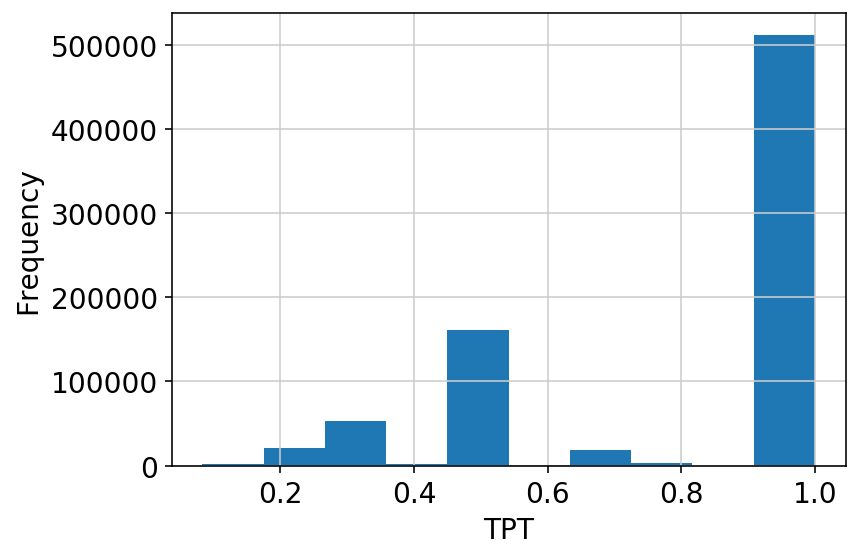

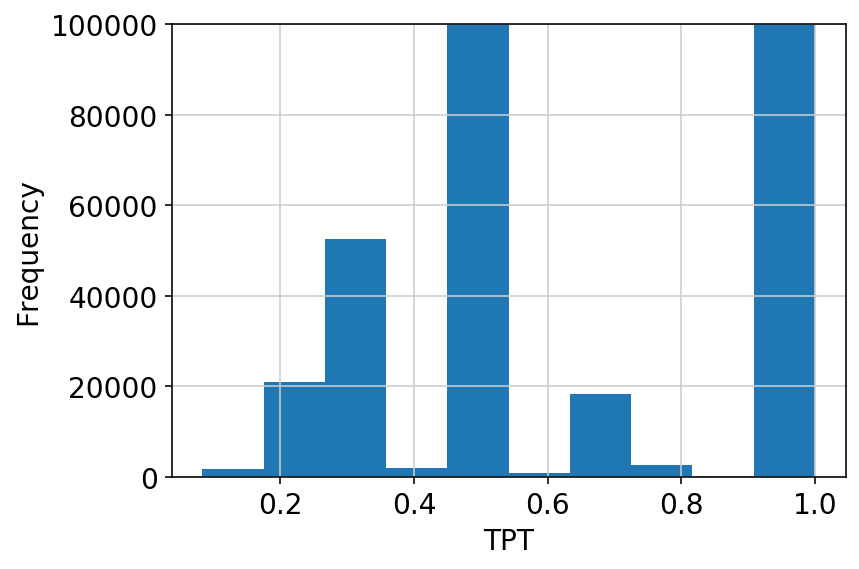

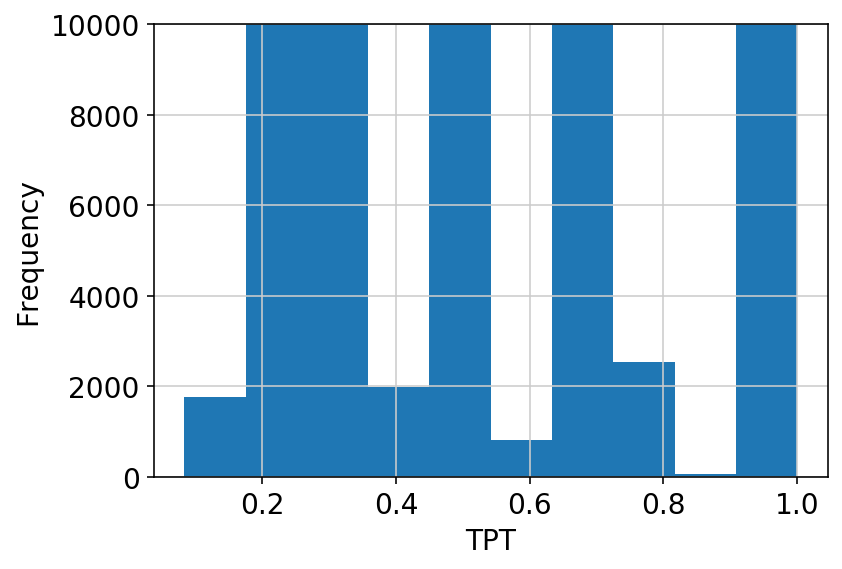

In [6]:
plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,100000)
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,10000)
plt.show()

In [7]:
#count cbc
cbc_umi_gbc=gbc_data.loc[:,['gbc','cbc','umi']]

print(cbc_umi_gbc.shape)
cbc_umi_gbc=cbc_umi_gbc.drop_duplicates()
cbc_umi_gbc.head()
print(cbc_umi_gbc.shape)

cbc_count=cbc_umi_gbc.groupby('cbc').size()

(772458, 3)
(631002, 3)


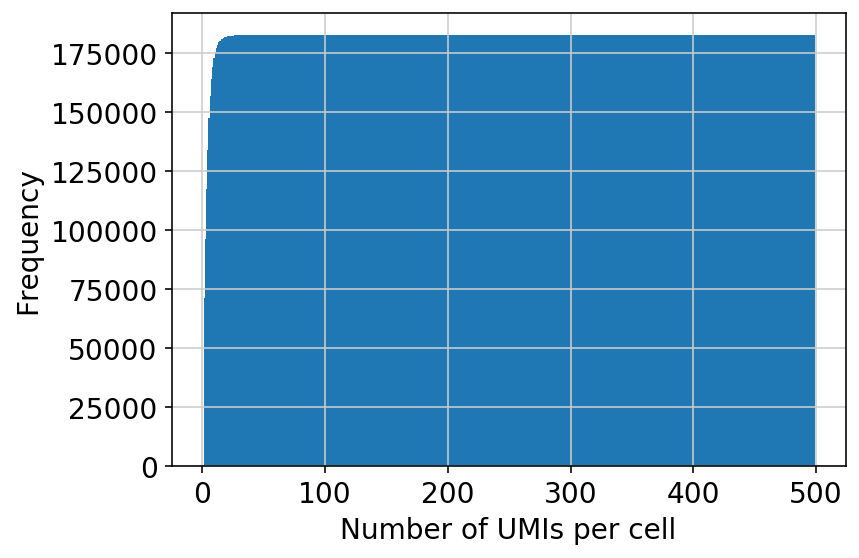

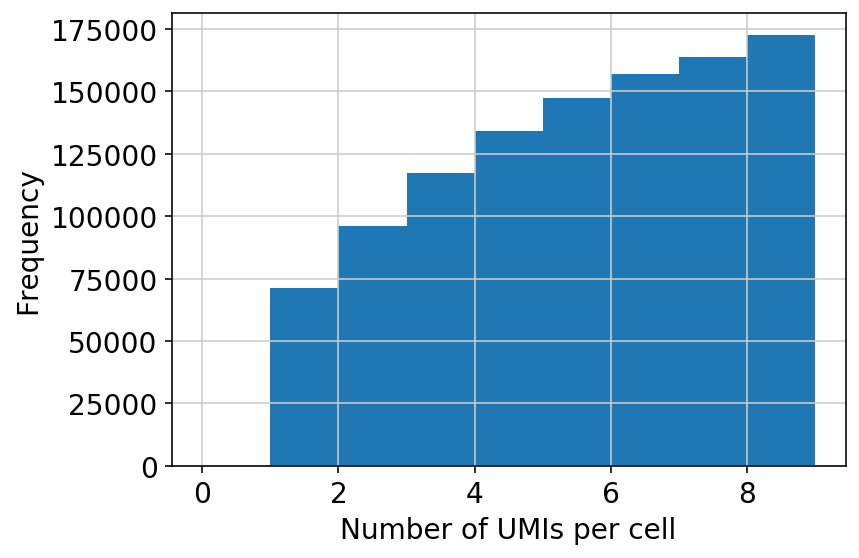

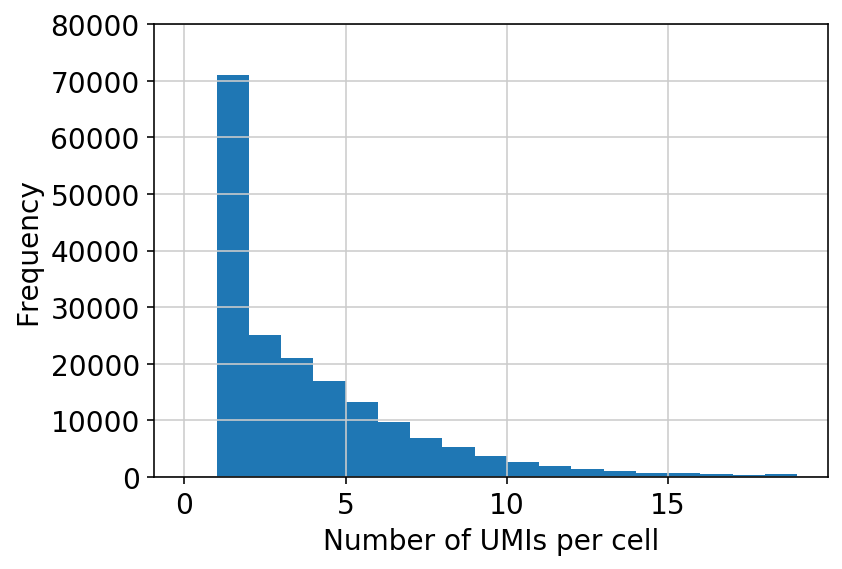

In [8]:
x=plt.hist(cbc_count,range(500),cumulative=True)
plt.xlabel('Number of UMIs per cell')
plt.ylabel('Frequency')
plt.show()
x=plt.hist(cbc_count,range(10),cumulative=True)
plt.xlabel('Number of UMIs per cell')
plt.ylabel('Frequency')
plt.show()
x=plt.hist(cbc_count,range(20))
plt.ylim(0,80000)
plt.xlabel('Number of UMIs per cell')
plt.ylabel('Frequency')
plt.show()

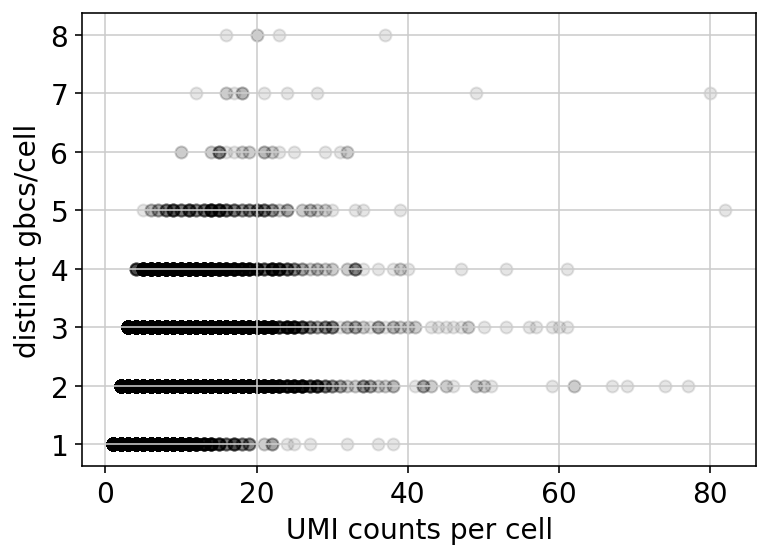

In [9]:
#plot the number of total reads per cell vs the number of gbcs
cbc_gbc=gbc_data.loc[:,['gbc','cbc']]
cbc_gbc=cbc_gbc.drop_duplicates()
gbc_per_cbc_count=cbc_gbc.groupby('cbc').size()

combo=pd.DataFrame({'umi_counts_per_cell':cbc_count,
                   'gbc_per_cell':gbc_per_cbc_count.loc[cbc_count.index]})

plt.scatter(combo['umi_counts_per_cell'],combo['gbc_per_cell'],color='black',alpha=0.1)
plt.xlabel('UMI counts per cell')
plt.ylabel('distinct gbcs/cell')
plt.show()

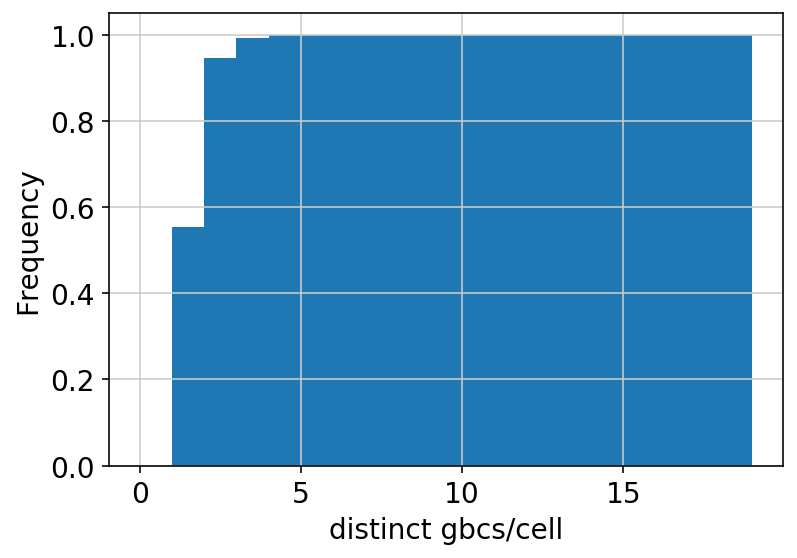

In [10]:
x=plt.hist(gbc_per_cbc_count,range(20),cumulative=True,density=True)
plt.xlabel('distinct gbcs/cell')
plt.ylabel('Frequency')
plt.show()

In [11]:
#check out the spike in TPT at 0.5

gbc_data.loc[gbc_data['TPT']==0.5,:].head()

,gbc,cbc,umi,cbc-umi-r2-count,cbc-umi-count,TPT
14,KRAS_p.Vl8Vl.24AG,AAAATGCCTCGCACTCch11,TTCATGTTGG,1,2,0.5
15,KRAS_p.Vl8Vl.24AG,AAAATGCCTCGCACTCch11,TTCATGTTGG,1,2,0.5
22,KRAS_T158A,AAACCGAGAGTGAGACch18,CTTGGGCCAT,1,2,0.5
23,KRAS_T158A,AAACCGAGAGTGAGACch18,CTTGGGCCAT,1,2,0.5
31,Puro_res,AAACCTAGACAGACCTch3,TTTCGTTCGT,1,2,0.5


(443789, 6)


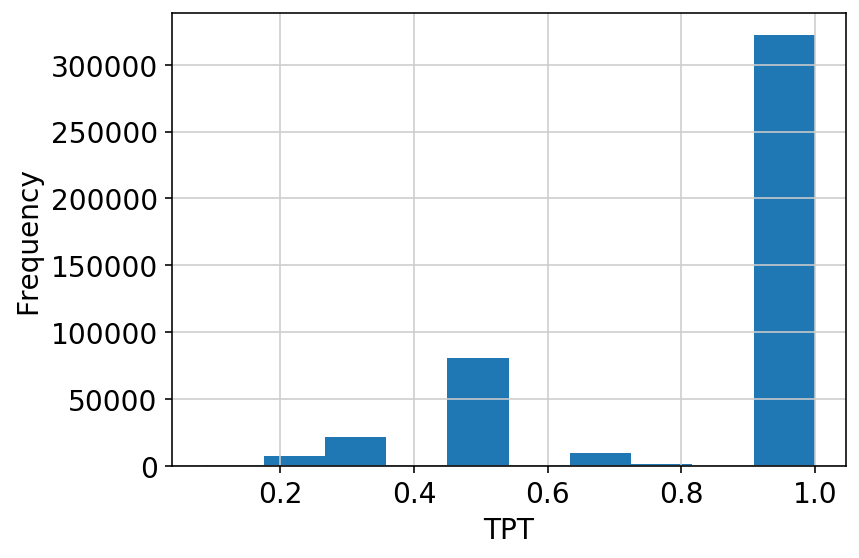

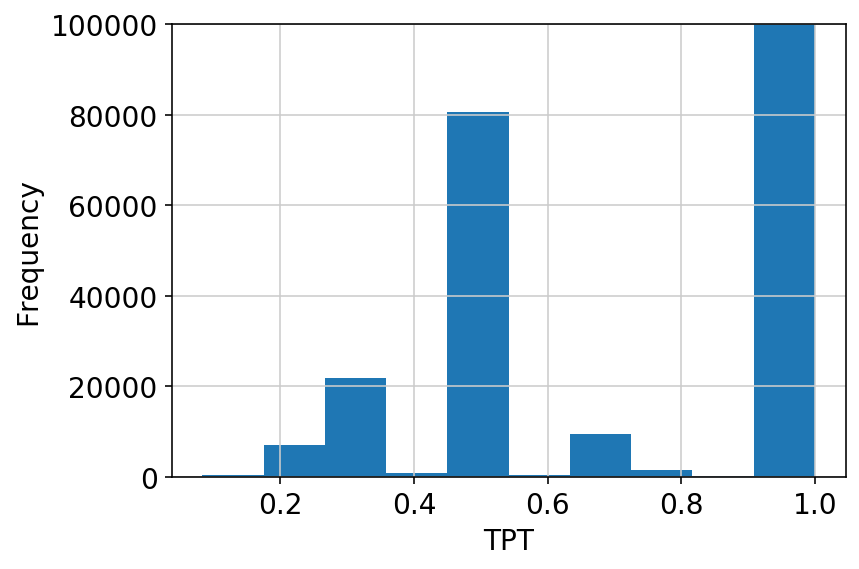

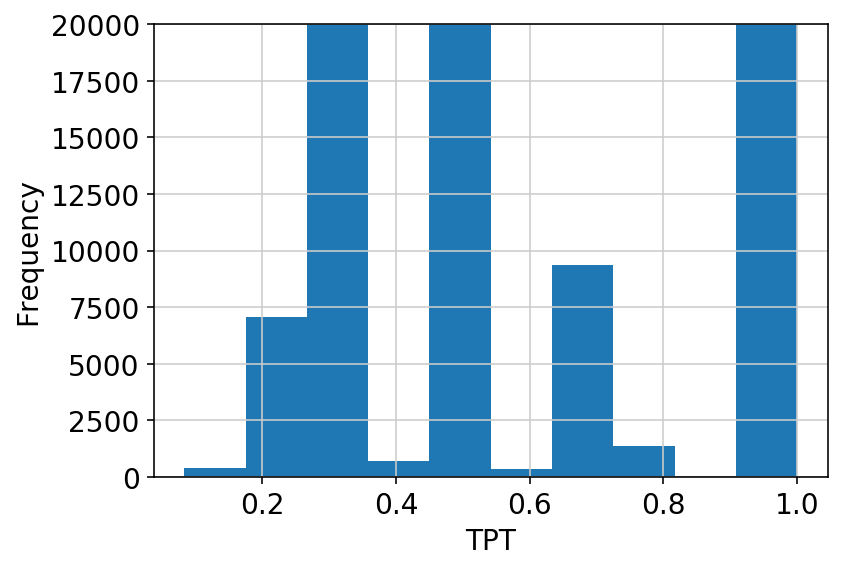

In [12]:
#let's look at the TPT after we filter out puro mapping reads

gbc_data=gbc_data.loc[gbc_data['gbc']!='Puro_res',:]
print(gbc_data.shape)

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,100000)
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,20000)
plt.show()

In [13]:
gbc_data.loc[gbc_data['TPT']==0.5,:].head()

,gbc,cbc,umi,cbc-umi-r2-count,cbc-umi-count,TPT
14,KRAS_p.Vl8Vl.24AG,AAAATGCCTCGCACTCch11,TTCATGTTGG,1,2,0.5
15,KRAS_p.Vl8Vl.24AG,AAAATGCCTCGCACTCch11,TTCATGTTGG,1,2,0.5
22,KRAS_T158A,AAACCGAGAGTGAGACch18,CTTGGGCCAT,1,2,0.5
23,KRAS_T158A,AAACCGAGAGTGAGACch18,CTTGGGCCAT,1,2,0.5
50,KRAS_R68S,AAACCTGAGAATGTGTch22,GTGCTTAGTT,1,2,0.5


In [14]:
gbc_data_original.loc[gbc_data_original['cbc']=="AAAATGCCTCGCACTCch11",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name
874,KRAS_p.Vl8Vl.24AG,GTTTAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCG...,44,-,AAAATGCCTCGCACTCch11,TTCATGTTGG,0,E00173:665:HH2H3CCXY:6:1216:26159:58409
2571,KRAS_p.Vl8Vl.24AG,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCGATTCTCCAC...,53,-,AAAATGCCTCGCACTCch11,TTCATGTTGG,0,E00342:556:HH2FNCCXY:6:2202:18456:63103


In [15]:
gbc_data_original.loc[gbc_data_original['cbc']=="AAACCGAGAGTGAGACch18",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name
110,KRAS_T158A,TTCTCGTCTAACACCAGCCCGGGCATTTTGTCTTACATAATTACAC...,84,-,AAACCGAGAGTGAGACch18,CTTGGGCCAT,0,E00173:665:HH2H3CCXY:7:1106:18335:68623
3269,KRAS_T158A,GAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACAC...,29,-,AAACCGAGAGTGAGACch18,CTTGGGCCAT,0,E00342:555:HGYTGCCXY:7:2201:23794:3120


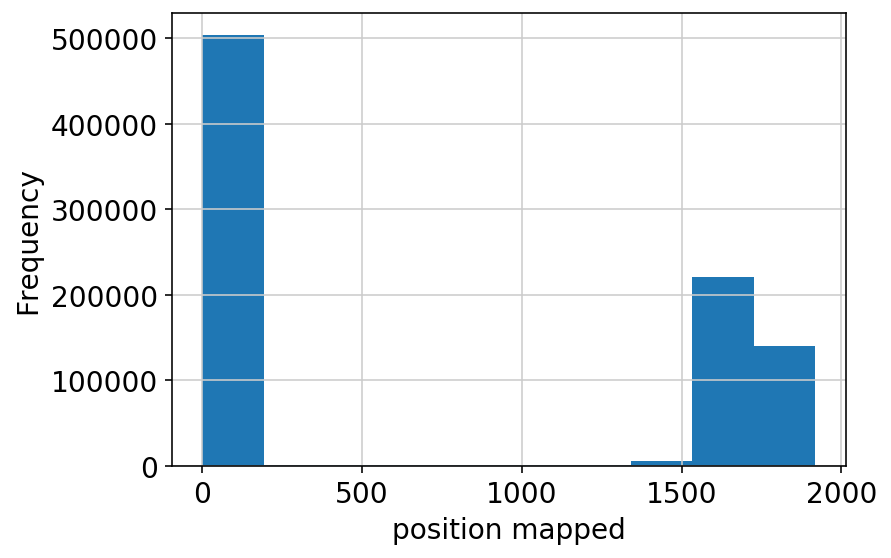

In [16]:
plt.hist(gbc_data_original['pos'])
plt.xlabel('position mapped')
plt.ylabel('Frequency')
#plt.ylim(0,200000)
plt.show()

In [17]:
#filter out ones that map to the wrong strand 
print(gbc_data_original.shape)
gbc_data_original=gbc_data_original.loc[gbc_data_original['strand']=='-',:]


(873672, 8)


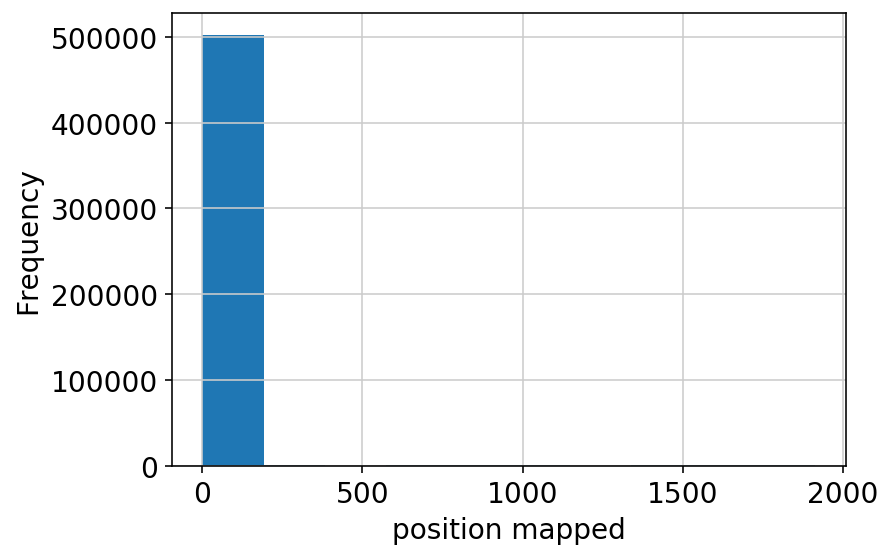

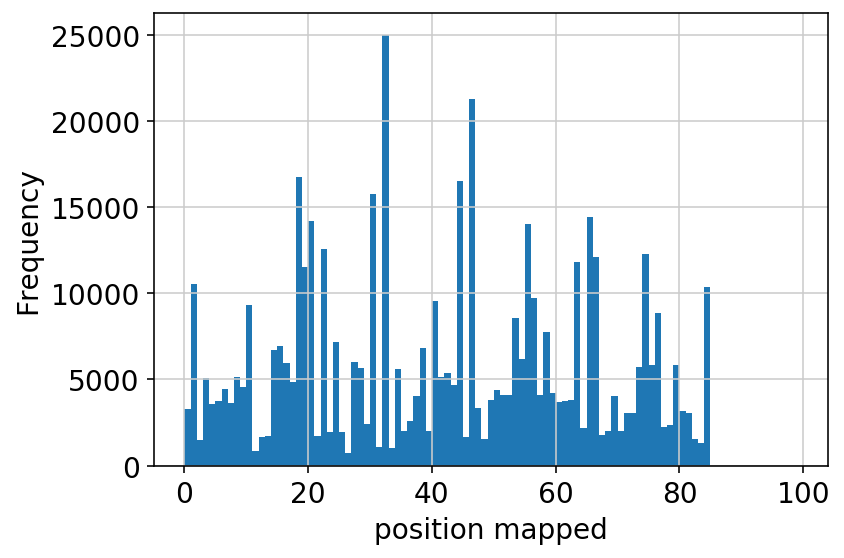

In [18]:
plt.hist(gbc_data_original['pos'])
plt.xlabel('position mapped')
plt.ylabel('Frequency')
plt.show()

plt.hist(gbc_data_original['pos'],range(100))
plt.xlabel('position mapped')
plt.ylabel('Frequency')
plt.show()

In [19]:
#nicely gets rid of reads that map completely in a different place.

#the fact that they map to diff positions within 100bp makes sense, 
#because reads can map anywhere as long as they overlap the guide barcode

In [20]:
#investigate tpt=0.5 more
gbc_data.loc[gbc_data['TPT']==0.5,:].head()

,gbc,cbc,umi,cbc-umi-r2-count,cbc-umi-count,TPT
14,KRAS_p.Vl8Vl.24AG,AAAATGCCTCGCACTCch11,TTCATGTTGG,1,2,0.5
15,KRAS_p.Vl8Vl.24AG,AAAATGCCTCGCACTCch11,TTCATGTTGG,1,2,0.5
22,KRAS_T158A,AAACCGAGAGTGAGACch18,CTTGGGCCAT,1,2,0.5
23,KRAS_T158A,AAACCGAGAGTGAGACch18,CTTGGGCCAT,1,2,0.5
50,KRAS_R68S,AAACCTGAGAATGTGTch22,GTGCTTAGTT,1,2,0.5


In [21]:
gbc_data_original.loc[gbc_data_original['cbc']=="AAAATGCCTCGCACTCch11",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name
874,KRAS_p.Vl8Vl.24AG,GTTTAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCG...,44,-,AAAATGCCTCGCACTCch11,TTCATGTTGG,0,E00173:665:HH2H3CCXY:6:1216:26159:58409
2571,KRAS_p.Vl8Vl.24AG,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCGATTCTCCAC...,53,-,AAAATGCCTCGCACTCch11,TTCATGTTGG,0,E00342:556:HH2FNCCXY:6:2202:18456:63103


In [22]:
gbc_data_original.loc[gbc_data_original['cbc']=="AAACCGAGAGTGAGACch18",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name
110,KRAS_T158A,TTCTCGTCTAACACCAGCCCGGGCATTTTGTCTTACATAATTACAC...,84,-,AAACCGAGAGTGAGACch18,CTTGGGCCAT,0,E00173:665:HH2H3CCXY:7:1106:18335:68623
3269,KRAS_T158A,GAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAATTAACAC...,29,-,AAACCGAGAGTGAGACch18,CTTGGGCCAT,0,E00342:555:HGYTGCCXY:7:2201:23794:3120


In [23]:
gbc_data_original.loc[gbc_data_original['cbc']=="AAACCTGAGAATGTGTch22",:]

,gbc,r2,pos,strand,cbc,umi,alignments,read_name
282,KRAS_R68S,GCGGGTTTAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTT...,40,-,AAACCTGAGAATGTGTch22,ATGTTTTGGG,0,E00173:665:HH2H3CCXY:7:1116:7537:17360
2765,KRAS_R68S,ACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCGTATCG...,50,-,AAACCTGAGAATGTGTch22,GTGCTTAGTT,0,E00173:665:HH2H3CCXY:7:1223:19157:6864
2974,KRAS_R68S,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCGTATCGCTC...,53,-,AAACCTGAGAATGTGTch22,TTATAAGCGC,0,E00173:665:HH2H3CCXY:7:2107:4249:21649
822,KRAS_R68S,GCGGGTTTAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTT...,40,-,AAACCTGAGAATGTGTch22,ATTTTTGTTT,0,E00342:555:HGYTGCCXY:7:1214:28777:23847
1845,KRAS_R68S,GCGGGTTTAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTT...,40,-,AAACCTGAGAATGTGTch22,ATTTTTGTTT,0,E00342:555:HGYTGCCXY:7:2214:30746:20471
4851,KRAS_R68S,CACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCTAGGTTAA...,22,-,AAACCTGAGAATGTGTch22,TTGGCCCTCG,0,E00342:555:HGYTGCCXY:7:1119:5325:71928
5237,KRAS_R68S,AGATGGCTGGCAACTAGAAGGCACAGTCGAGGCTGATCAGCGGGTT...,1,-,AAACCTGAGAATGTGTch22,TATCCGAGCC,0,E00342:555:HGYTGCCXY:7:1212:15757:36346
2367,KRAS_R68S,GGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCGTATCGCTC...,53,-,AAACCTGAGAATGTGTch22,GCGTTCCACC,0,E00173:666:HGY7FCCXY:7:1114:4706:5880
2594,KRAS_R68S,TTAAACGGGCCCTCTAGGTTAATTAACACCACGCTAGCTTCTCCGT...,46,-,AAACCTGAGAATGTGTch22,CGCAACGGGG,0,E00173:666:HGY7FCCXY:7:1123:29670:20084
4096,KRAS_R68S,TAGAAGGCACAGTCGAGGCTGATCAGCGGGTTTAAACGGGCCCTCT...,15,-,AAACCTGAGAATGTGTch22,TTGTCGTCGG,0,E00173:666:HGY7FCCXY:7:2212:8004:26044


In [24]:
#the examples i am seeing here involve different reads, 
#but mapping to diff positions of the same gbc

#let's do a modified TPT that only looks at the gbc mapped, not at the actual read.
#if this is the only case that accounts for TPT=0.5, then we understand where it is coming from


In [25]:
def compute_TPT_lenient(gbcs_dataset):
    
    '''
    input: pandas data frame with the columns "cbc", "umi", "gbc", "r2" where every row is a read 
    output: pandas data frame with the columns "gbc", "cbc", "umi", "cbc-umi-r2-count", "cbc-umi-count", "TPT"
    NOTE: for the input, multiple reads corresponding to the same cbc-umi combination should be listed as separate lines!
    '''

    import copy
    import re
    import time

    print("======== annotating cbc-umi pairs, and cbc-umi-r2")
    gbcs_dataset['cbcumi']=[x+'-'+y for x,y in zip(gbcs_dataset['cbc'],gbcs_dataset['umi'])]
    cbcumir2=list([x+'+'+y for x,y in zip(gbcs_dataset['cbcumi'],gbcs_dataset['r2'])])
    gbcs_dataset['cbcumir2']=list([x+'_gbc_'+y for x,y in zip(cbcumir2,gbcs_dataset['gbc'])])

    print("======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi")
    cbcumi_group=gbcs_dataset.groupby('cbcumi').size()
    cbcumi_r2_group=gbcs_dataset.groupby('cbcumir2').size()
    cbcumi_from_grouped_reads=[x.split('+')[0] for x in cbcumi_r2_group.index]

    print("======== computing TPT")
    #divide every cbc-umi-r2 value by the cbc-umi values 
    combo_counts=pd.DataFrame({'cbc-umi-r2':cbcumi_r2_group,
                              'cbc-umi-r2-name':cbcumi_r2_group.index,
                              'cbc-umi':cbcumi_from_grouped_reads})
    combo_counts['cbc-umi-total']=copy.deepcopy(list(cbcumi_group.loc[combo_counts['cbc-umi']]))
    combo_counts['TPT']=1.0*combo_counts['cbc-umi-r2']/combo_counts['cbc-umi-total']
    
    combo_counts['gbc']=list([x.split('_gbc_')[1] for x in list(combo_counts.loc[:,'cbc-umi-r2-name'])])
    combo_counts['umi']=list([x.split('-')[1] for x in list(combo_counts['cbc-umi'])])
    combo_counts['cbc']=list([x.split('-')[0] for x in list(combo_counts['cbc-umi'])])
    
    print("======== compiling the final result")
    to_return=pd.DataFrame({'gbc':combo_counts['gbc'],
                           'cbc':combo_counts['cbc'],
                           'umi':combo_counts['umi'],
                           'cbc-umi-r2-count':combo_counts['cbc-umi-r2'],
                           'cbc-umi-count':combo_counts['cbc-umi-total'],
                           'TPT':combo_counts['TPT']})
    to_return=to_return.reset_index(drop=True)
    return(to_return)

gbc_data_original_lenient=copy.deepcopy(gbc_data_original)
gbc_data_original_lenient['r2']=gbc_data_original_lenient['gbc']
gbc_data=compute_TPT(gbc_data_original_lenient)

======== annotating cbc-umi pairs, and cbc-umi-r2
======== counting the numbers of reads supporting cbc-umi-r2 and for denominator cbc-umi
======== computing TPT
======== compiling the final result


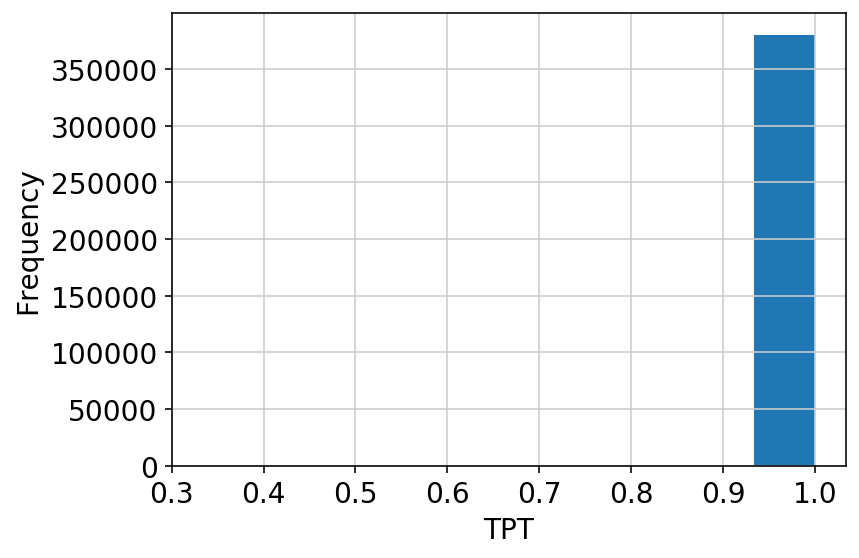

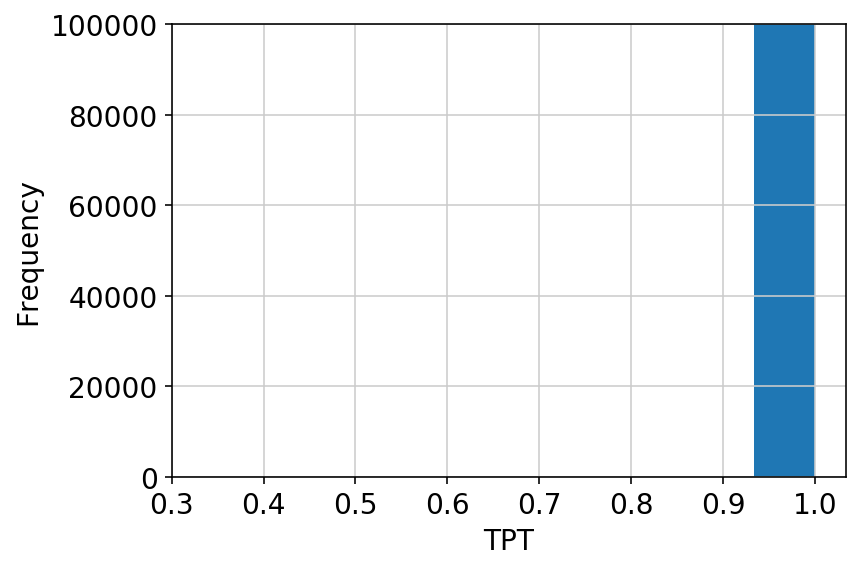

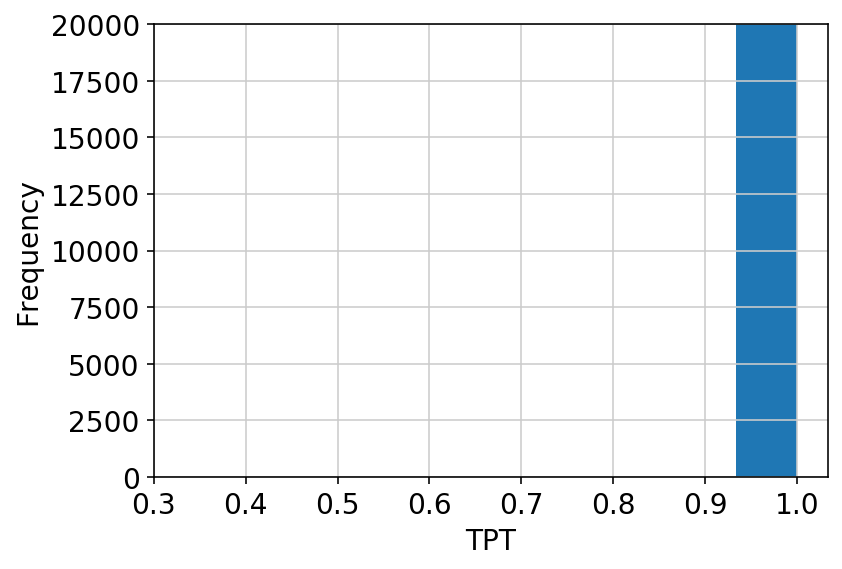

In [26]:
plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,100000)
plt.show()

plt.hist(gbc_data['TPT'])
plt.xlabel('TPT')
plt.ylabel('Frequency')
plt.ylim(0,20000)
plt.show()

In [27]:
#awesome.

Summary of cell TPT analysis
==

1. Read the mapped reads directly, to avoid useless extra code.
2. Filter for vbcs that map to the - strand. They are the only valid ones.
3. The rest of the TPT<1 reads appear because they are different reads mapping to different positions of the same vbc. Thus, it is safe not to do TPT filtering, since all reads with the same cbc-umi map to the same vbc in the end.